我们在图像退化的相关章节里已经介绍过，如果已知退化函数 $H(u, v)$ 我们可以通过逆滤波的方式来恢复图像。即，对于退化图像 $G(u, v)$ 来说，可以通过以下方式得到复原图像 $\hat{F} (u, v)$

$$
\hat{F}(u, v) = \frac{G(u, v)}{H(u, v)}
$$

这个过程有个统一的称呼——逆滤波，不过这里要知道，无论怎么做 $F(u, v) \neq \hat{F}(u, v)$。也就是说，复原后的图像，仍然在细节上和原图像有一定的差别。

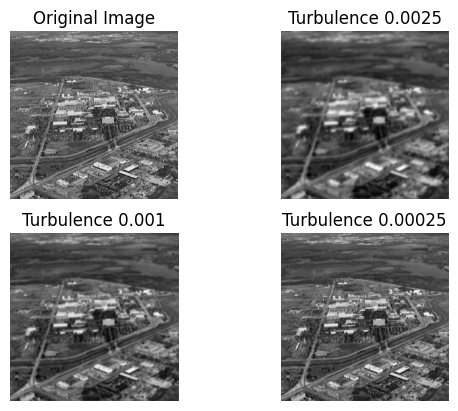

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def degradation_kernel(dft, k):
    # derive width, height, channel
    width, height, _ = dft.shape

    # center pointer
    p = width / 2 + 1.0
    q = height / 2 + 1.0

    # generate an empty kernel
    kernel = np.zeros((width, height), dtype=np.float32)

    # generate turbulence kernel
    for u in range(width):
        for v in range(height):
            power = -k * np.power((u - p) ** 2 + (v - q) ** 2, 5 / 6)
            kernel[u, v] = np.power(np.e, power)

    return kernel


def update_dft_with_degradation(dft, kernel):

    # derive width, height, channel
    # width, height, _ = dft.shape

    # shift dft
    dft_backup = np.fft.fftshift(dft)

    # apply the kernel
    dft_backup[:, :, 0] = dft_backup[:, :, 0] * kernel
    dft_backup[:, :, 1] = dft_backup[:, :, 1] * kernel

    # shift back
    dft_backup = np.fft.fftshift(dft_backup)

    return dft_backup


def turbulence_deterioration(img, k):

    # convert byte to float
    dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)

    # generate turbulence degradation
    kernel = degradation_kernel(dft, k)

    # apply kernel
    final_dft = update_dft_with_degradation(dft, kernel)

    # convert dft image back
    final_img = cv2.idft(final_dft, flags=cv2.DFT_COMPLEX_INPUT | cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)

    # return
    return final_img


if __name__ == "__main__":

    # load image from file
    BASE_DIR = "/opt/images/DIPRawImageDataset/DIP3E_CH05_Original_Images/DIP3E_CH05_Original_Images"
    img = cv2.imread(os.path.join(BASE_DIR, "Fig0525(a)(aerial_view_no_turb).tif"), cv2.IMREAD_GRAYSCALE)

    img_with_0025 = turbulence_deterioration(img, 0.0025)
    img_with_001 = turbulence_deterioration(img, 0.001)
    img_with_00025 = turbulence_deterioration(img, 0.00025)

    plt.subplot(2, 2, 1)
    plt.imshow(img, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.imshow(img_with_0025, cmap="gray")
    plt.title("Turbulence 0.0025")
    plt.axis("off")

    plt.subplot(2, 2, 3)
    plt.imshow(img_with_001, cmap="gray")
    plt.title("Turbulence 0.001")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.imshow(img_with_00025, cmap="gray")
    plt.title("Turbulence 0.00025")
    plt.axis("off")

    plt.show()

# 对湍流的逆滤波

要对湍流退化的图像进行逆操作（即还原），通常使用**逆滤波（Inverse Filtering）**或**维纳滤波（Wiener Filtering）**来恢复图像。这些方法利用已知的退化核进行复原处理。不过，由于湍流退化往往导致频率信息的丢失，复原效果可能无法完全还原原始图像，但可以一定程度上减轻退化效果。

我们知道，[湍流模型](https://seagochen.blog.csdn.net/article/details/116236391) 的退化函数为：

$$H(u, v) = e ^{-k(u^2 + v^2)^{5/6}}$$

所以取反后的滤波函数为：

$$H(u, v) ^{-1}= e ^{k(u^2 + v^2)^{5/6}}$$


### 实现逆滤波的步骤

以下是使用逆滤波进行图像复原的步骤。

#### 1. 准备逆滤波核
从已知的退化核生成逆滤波核，以便在频域上反转湍流退化。

#### 2. 应用逆滤波
在频域上使用逆滤波核乘以退化图像的傅里叶变换，从而逆转退化。

#### 3. 转换回空域
对逆滤波后的图像执行逆傅里叶变换，将图像还原至空域。

### 逆滤波代码示例

以下代码实现了对湍流退化图像的逆滤波复原操作。

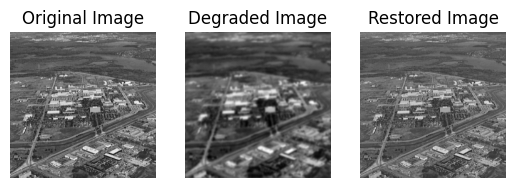

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def inverse_degradation_kernel(kernel, epsilon=1e-5):
    # 防止除零，通过加入微小值 epsilon 来稳定逆滤波核
    inverse_kernel = np.zeros_like(kernel)
    inverse_kernel[kernel > epsilon] = 1 / (kernel[kernel > epsilon] + epsilon)
    return inverse_kernel

def apply_inverse_filter(dft, inverse_kernel):
    # Shift DFT to center, apply inverse filter, then shift back
    dft_shifted = np.fft.fftshift(dft)
    dft_shifted[:, :, 0] *= inverse_kernel
    dft_shifted[:, :, 1] *= inverse_kernel
    dft_restored = np.fft.ifftshift(dft_shifted)
    return dft_restored

def inverse_turbulence_restoration(img, k):
    # 计算图像的傅里叶变换
    dft = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)

    # 使用退化核生成湍流核
    kernel = degradation_kernel(dft, k)

    # 生成逆滤波核
    inverse_kernel = inverse_degradation_kernel(kernel)

    # 应用逆滤波
    restored_dft = apply_inverse_filter(dft, inverse_kernel)

    # 逆傅里叶变换恢复图像
    restored_img = cv2.idft(restored_dft, flags=cv2.DFT_COMPLEX_INPUT | cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)

    return restored_img

# 测试逆操作
if __name__ == "__main__":
    # 加载湍流退化后的图像
    img_with_turbulence = img_with_0025  # 选择退化后的图像进行复原

    # 复原图像
    restored_img = inverse_turbulence_restoration(img_with_turbulence, 0.0025)

    # 显示原始、退化和复原后的图像
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(img_with_turbulence, cmap="gray")
    plt.title("Degraded Image")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(restored_img, cmap="gray")
    plt.title("Restored Image")
    plt.axis("off")

    plt.show()


### 代码解释

1. **`inverse_degradation_kernel`**：生成逆滤波核。为防止除零错误，设置了一个微小值`epsilon`来稳定核的计算。

2. **`apply_inverse_filter`**：将逆滤波核应用到频域中的退化图像，以求复原频谱。

3. **`inverse_turbulence_restoration`**：集成上述步骤，生成逆滤波复原后的图像。

### 注意事项

逆滤波容易放大图像中的噪声，尤其是在退化核的频率值较小的区域。这时可以通过**维纳滤波**进一步优化复原效果，它能更好地平衡噪声和细节复原。如果逆滤波的结果仍不理想，可以考虑使用维纳滤波。